# Matched Synthetic Fluorescent Image Generation

In [1]:
import os
# os.environ["JOBLIB_TEMP_FOLDER"] = "C:/temp"
# os.makedirs("C:/temp", exist_ok=True)
os.makedirs("D:/temp", exist_ok=True)
os.environ["JOBLIB_TEMP_FOLDER"] = "D:/temp"

In [2]:
all_synth_imgs = []
all_synth_lbls = []
all_synth_chs  = []

## Extract parameters from target real experiment

In [3]:
# ────────────────────────────── Cell 1 ──────────────────────────────
# Set the path to your metadata text file
META_TXT = r"D:\PRISM\metadata_nd2_barcode20250324_0110.txt"
# metadata_nd2_barcode20250307_0010.txt
# metadata_nd2_barcode20250310_1100.txt
# metadata_nd2_barcode20250324_1010.txt
# metadata_nd2_barcode20250324_0110.txt
# metadata_nd2_barcode20250324_0111.txt
# metadata_nd2_barcode20250324_1001.txt
# metadata_nd2_barcode20250319_0011.txt
import re, sys, os, random, pickle
sys.path.insert(1, r"D:\PRISM")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tifffile import imread, imsave
from skimage.util import random_noise
from skimage import img_as_ubyte
import zarr

# ── helper to parse the metadata txt ────────────────────────────────
def parse_metadata(txt_path):
    """Return dict with channels, wavelengths, NA, RI, pixel_size_nm."""
    with open(txt_path, encoding="utf-8") as fh:
        text = fh.read()

    # Numerical aperture
    na = float(re.search(r"Numerical Aperture: *([\d.]+)", text).group(1))

    # Refractive index
    ri = float(re.search(r"Refractive Index: *([\d.]+)", text).group(1))

    # pixel size (µm)  → convert to nm
    pix = float(re.search(r"x voxel size is *([\d.]+) microns", text).group(1))
    p_real_nm = pix * 1000

    # find planes: Name line + filter line with (nnn/xx)
    planes = re.findall(r"Plane #\d+:\s+[\s\S]*?Name: *(\w+)[\s\S]*?FilterChanger\(EM Wheel1\): *\d+ *\((\d+)/", 
                        text, flags=re.IGNORECASE)
    channels = []
    wavelengths = {}
    for name, centre in planes:
        chan = name.upper()
        if chan in ("BFP","CFP","GFP","YFP","RFP","CY5","DAPI"):
            channels.append(chan)
            wavelengths[chan] = int(centre)

    # ensure unique order-preserving list
    channels = list(dict.fromkeys(channels))
    return dict(channels=channels, wavelengths=wavelengths,
                NA=na, RI=ri, p_real=p_real_nm)

meta = parse_metadata(META_TXT)

# ── populate variables from metadata ───────────────────────────────
ALL_CHANNELS = meta["channels"]
WAVELENGTHS  = meta["wavelengths"]

# defaults (keep existing tables for channels that appear)
LUM_MATCH = {
    'BFP':{'M':83,'S':61},
    'GFP':{'M':102,'S':44},
    'RFP':{'M':80,'S':52},
    'CY5':{'M':39,'S':54}
}
BG_LUM_MATCH = {
    'BFP':{'M':123,'S':36},
    'GFP':{'M':125,'S':35},
    'RFP':{'M':129,'S':36},
    'CY5':{'M':114,'S':47}
}

# noise & sampling (leave as before; tweak if you wish)
GAUSS_NOISE_SIGMA = {'BFP':0.007,'GFP':0.02,'RFP':0.003,'CY5':0.003}
# GAUSS_NOISE_SIGMA = {'BFP':0.01,'GFP':0.02,'RFP':0.01,'CY5':0.003}
PERI_PROPORTION   = {'BFP':0.2,'GFP':0.8,'RFP':0.15,'CY5':0.2}
CAMERA_BIAS       = 0.1
ALPHA             = 0.8

# pixel scales & segmentation
P_GEN   = 30                              # nm / px (synthetic grid)
P_REAL  = meta["p_real"]                  # nm / px from metadata
USE_RECT = True
MASK_CEN = [0.5,0.5]

# cell geometry + optics
L_RANGE        = [400,2000]
OUTER_R_RANGE  = [350,410]
PERI_RANGE     = [40,50]
TRENCH_WIDTH   = 1500
BRIGHTNESS_CUTOFF = 0.1

NUC_TYPES   = ['spherocylinder','twin-spherocylinder']
NA, N_REF_INDEX = meta["NA"], meta["RI"]

# log what we parsed
print("Channels :", ALL_CHANNELS)
print("λ centres:", WAVELENGTHS)
print(f"NA={NA},  RI={N_REF_INDEX},  pixel={P_REAL:.1f} nm/px")

# ── import project-specific code ───────────────────────────────────
from Synthetic_Data_Generation.cell import Cell
from Synthetic_Data_Generation.microscope import Microscope
from utils import normalize_image, get_noisy_background, segment_synthetic_cell


Channels : ['RFP', 'BFP']
λ centres: {'RFP': 595, 'BFP': 435}
NA=1.45,  RI=1.515,  pixel=65.0 nm/px


Found 51 cells; showing first 5: ['T0001.zarr', 'T0021.zarr', 'T0025.zarr', 'T0039.zarr', 'T0043.zarr']

Dataset structure:
 /
 ├── bfp (64, 36) uint16
 ├── pc (64, 36) uint16
 └── rfp (64, 36) uint16
Using array key: bfp
Loaded 51 real images.


(-0.5, 35.5, 63.5, -0.5)

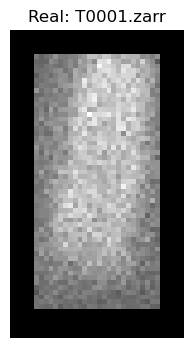

In [4]:
# Cell 2: Discover & Load Real Zarr Crops
import os, zarr
from utils import normalize_image
import matplotlib.pyplot as plt

# adjust this to your “clear_mother” parent folder
DATA_DIR = r"D:\PRISM\1010_clear_mother"

# list all cell folders
cell_folders = sorted([
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d))
])
print("Found", len(cell_folders), "cells; showing first 5:", cell_folders[:5])

# peek at the first folder’s contents
sample0 = os.path.join(DATA_DIR, cell_folders[0])
z0 = zarr.open(sample0, mode='r')
print("\nDataset structure:\n", z0.tree())

# get the first array key
ARR_KEY = list(z0.array_keys())[0]
print("Using array key:", ARR_KEY)

# load all real images into a list
real_images = []
for folder in cell_folders:
    arr = zarr.open(
        os.path.join(DATA_DIR, folder),
        mode='r'
    )[ARR_KEY][:]
    real_images.append(normalize_image(arr))

print("Loaded", len(real_images), "real images.")

# display one example
plt.figure(figsize=(4,4))
plt.imshow(real_images[0], cmap='gray')
plt.title(f"Real: {cell_folders[0]}")
plt.axis('off')


Compute image statistics for the target real experiment

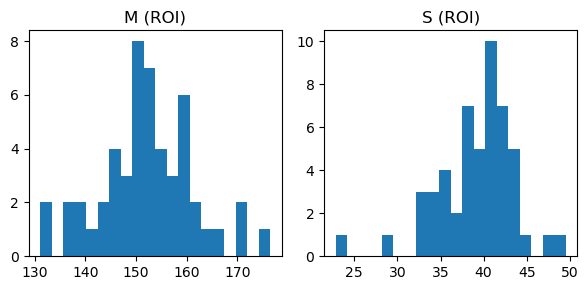

In [5]:
# Cell X: Compute mean/std over the actual fluorescent ROI only
from skimage import img_as_ubyte

MS_list = []
for img in real_images:
    # mask out the zero padding
    mask = img > 0
    ys, xs = np.where(mask)
    if ys.size == 0:
        # fallback to whole image if no nonzeros
        crop = img
    else:
        crop = img[ys.min():ys.max()+1, xs.min():xs.max()+1]
    u8 = img_as_ubyte(crop)
    MS_list.append((u8.mean(), u8.std()))

# visualize
Ms, Ss = zip(*MS_list)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.hist(Ms, bins=20); plt.title("M (ROI)")
plt.subplot(1,2,2); plt.hist(Ss, bins=20); plt.title("S (ROI)")
plt.tight_layout()


In [6]:
# Cell X (ROI‐masked): Infer noise_mu and noise_sigma from real_images
import numpy as np
from skimage import img_as_ubyte

bg_vals = []
for img in real_images:
    # 1) mask zeros (padding) to isolate the real rectangle
    roi_mask = img > 0
    if not roi_mask.any():
        roi = img.flatten()
    else:
        ys, xs = np.where(roi_mask)
        roi = img[ys.min():ys.max()+1, xs.min():xs.max()+1].flatten()

    # 2) pick the bottom 20% of ROI pixels
    cutoff = np.percentile(roi, 20)
    bg = roi[roi < cutoff]
    if bg.size == 0:
        bg = roi
    bg_vals.append(bg)

# 3) concatenate and convert
all_bg = np.concatenate(bg_vals)
all_bg = np.clip(all_bg, 0, 1)        # ensure bounds
u8_bg  = img_as_ubyte(all_bg)

# 4) normalize to [0,1]
noise_mu    = u8_bg.mean()  / 255.0
noise_sigma = u8_bg.std()   / 255.0

print(f"Inferred noise_mu    = {noise_mu:.3f}")
print(f"Inferred noise_sigma = {noise_sigma:.3f}")


Inferred noise_mu    = 0.397
Inferred noise_sigma = 0.054


## Image Generation

In [8]:
def generate_synthetic_for_real(real_img, M, S, channel=None, label=None):
    """
    real_img: 2D normalized image (H×W)
    M,S: mean/std over the real-cell ROI
    Returns: synthetic image of shape H×W, label, channel
    """
    H, W = real_img.shape

    # 1) pick channel & label
    channel = channel or random.choice(ALL_CHANNELS)
    label   = label if label is not None else random.choice([0,1,2,3])
    if channel=='CY5': label=2

    # 2) background‐only case
    if label == 0:
        # 1) base and min sizes
        min_h = int(H / 3)
        min_w = int(W / 3)

        # 2) random height
        roi_h = random.randint(min_h, H-1)

        # 3) aspect‐ratio noise around W/H
        base_ratio = W / H
        # sample noise factor in [0.7, 1.3]
        ratio_noise = random.uniform(0.7, 1.3)
        r = base_ratio * ratio_noise

        # 4) compute width, clip
        roi_w = int(roi_h * r)
        roi_w = max(min_w, min(roi_w, W-1))

        # 5) generate the patch
        bg_roi = get_noisy_background((roi_h, roi_w), 1, noise_mu, noise_sigma)
        bg_roi = normalize_image(bg_roi)

        u8 = img_as_ubyte(bg_roi)
        M0, S0 = BG_LUM_MATCH[channel]['M'], BG_LUM_MATCH[channel]['S']
        lum = ((u8 - u8.mean())/u8.std()) * S0 + M0
        crop = (lum/255.0).clip(0,1)

        # 6) center‐paste
        canvas = np.zeros((H, W), dtype=crop.dtype)
        y_off = (H - roi_h) // 2
        x_off = (W - roi_w) // 2
        canvas[y_off:y_off+roi_h, x_off:x_off+roi_w] = crop

        return canvas, 0, channel

    # 3–4) build & sample cell (same as before) …
    outer_r = random.randint(*OUTER_R_RANGE)
    l       = random.randint(*L_RANGE)
    peri    = random.randint(*PERI_RANGE)
    center  = [min(max(random.gauss(0.5,0.03),0.4),0.6) for _ in (0,1)]

    cell = Cell(l, outer_r, peri, random.choice(NUC_TYPES),
                P_GEN, np.round(np.array((H,W))*P_REAL/P_GEN).astype(int),
                BRIGHTNESS_CUTOFF, TRENCH_WIDTH)
    cell.generate_3D_cell()
    rot = random.uniform(-cell.get_max_rotation_angle(),
                         cell.get_max_rotation_angle())

    objs, ints, cuts = [], [], []
    if label in (1,3):
        m = cell.sample_from_component(cell.periplasm, PERI_PROPORTION[channel])
        objs.append(m); ints.append(0.1); cuts.append(1)
    if label in (2,3):
        m = cell.sample_from_component(cell.nucleoid, 0.5)
        objs.append(m); ints.append(0.1); cuts.append(0)
    if random.random()<0.3:
        m = cell.sample_from_component(cell.upper_neighbour, 0.3)
        objs.append(m); ints.append(0.08); cuts.append(0)

    # 5–6) project, blur, resize, noise (same)
    img = cell.get_greyScale_image(objs, ints, cuts, rot, center)
    mch = Microscope(P_REAL, WAVELENGTHS[channel], NA, N_REF_INDEX)
    img = mch.convolve_with_Gaussian(img, P_GEN)
    img = mch.resize_image(img, (H,W))
    img = random_noise(img, mode='poisson')
    img = ALPHA*img + CAMERA_BIAS
    img = random_noise(img, mode='gaussian', var=GAUSS_NOISE_SIGMA[channel]**2)

    # 7) normalize (float 0–1)
    img = normalize_image(img)

    # 8) segment + dilate to get loose crop
    seg = segment_synthetic_cell(img, cell, rot, USE_RECT, MASK_CEN, erode=True)
    from skimage.morphology import binary_dilation, disk
    dil = binary_dilation(seg>0, disk(2))
    ys, xs = np.where(dil)
    y0, y1 = ys.min(), ys.max()+1
    x0, x1 = xs.min(), xs.max()+1

    # 9) crop the noisy+blurred image
    crop = img[y0:y1, x0:x1]

    # 10) lum-match the crop using ROI stats M,S
    u8_crop  = img_as_ubyte(crop)
    lum      = ((u8_crop - u8_crop.mean())/u8_crop.std()) * S + M
    crop_lum = (lum/255.0).clip(0,1)

    # 10.5) smooth / interpolate for natural gradients
    from scipy.ndimage import gaussian_filter
    crop_lum = gaussian_filter(crop_lum, sigma=0.5)

    # 11) ensure no zeros inside ROI
    zero_mask = (crop_lum == 0)
    if zero_mask.any():
        noise_patch = get_noisy_background(crop_lum.shape, 1, noise_mu, noise_sigma)
        noise_patch = normalize_image(noise_patch)
        u8_noise   = img_as_ubyte(noise_patch)
        M0, S0     = BG_LUM_MATCH[channel]['M'], BG_LUM_MATCH[channel]['S']
        lum_noise  = ((u8_noise - u8_noise.mean())/u8_noise.std()) * S0 + M0
        noise_lum  = (lum_noise/255.0).clip(0,1)
        crop_lum[zero_mask] = noise_lum[zero_mask]

    # 12) center-pad back onto the H×W canvas
    canvas = np.zeros((H,W), dtype=crop_lum.dtype)
    h, w   = crop_lum.shape
    y_off  = (H-h)//2
    x_off  = (W-w)//2
    canvas[y_off:y_off+h, x_off:x_off+w] = crop_lum

    return canvas, label, channel

Channel: RFP, Label: 0
PSNR (ROI)     : 5.86 dB
Mean: real=0.588, synth=0.119  → Δ=-0.469
Var : real=0.0263, synth=0.0508    → Δ=0.0245


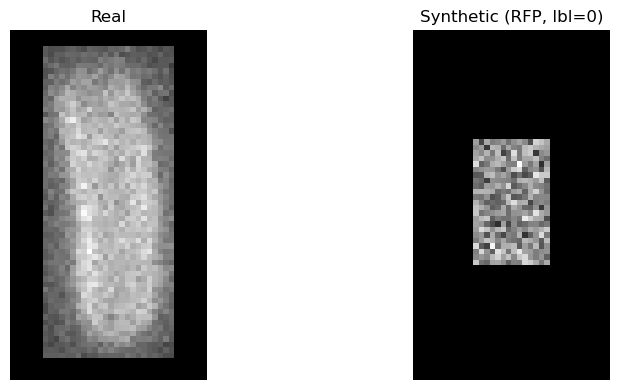

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio
from skimage import img_as_ubyte

# pick one real image
ri, (M0, S0) = real_images[7], MS_list[7]
syn, lbl, ch = generate_synthetic_for_real(ri, M0, S0)

# 1. compute nonzero ROI mask
roi_mask = ri > 0
ys, xs = np.where(roi_mask)
y0, y1 = ys.min(), ys.max()+1
x0, x1 = xs.min(), xs.max()+1

# 2. crop both real and synth to ROI
real_crop = ri[y0:y1, x0:x1]
syn_crop  = syn[y0:y1, x0:x1]

# 3. metrics in ROI
psnr = peak_signal_noise_ratio(real_crop, syn_crop, data_range=1.0)
mean_real = real_crop.mean()
mean_synth = syn_crop.mean()
var_real = real_crop.var()
var_synth = syn_crop.var()

print(f"Channel: {ch}, Label: {lbl}")
print(f"PSNR (ROI)     : {psnr:.2f} dB")
print(f"Mean: real={mean_real:.3f}, synth={mean_synth:.3f}  → Δ={mean_synth - mean_real:.3f}")
print(f"Var : real={var_real:.4f}, synth={var_synth:.4f}    → Δ={var_synth - var_real:.4f}")

# 4. Show real vs synthetic
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(ri, cmap='gray')
ax[0].set_title("Real")
ax[1].imshow(syn, cmap='gray')
ax[1].set_title(f"Synthetic ({ch}, lbl={lbl})")
for a in ax: a.axis('off')
plt.tight_layout()
plt.show()


generate

In [ ]:
# Generate synthetic images using the statistics of randomly chosen real examples

import random
# NUC_TYPES   = ['spherocylinder','twin-spherocylinder']
NUC_TYPES   = ['spherocylinder']
NUM_SYN = 20
# all_synth_imgs = []
# all_synth_lbls = []
# all_synth_chs  = []

for i in range(NUM_SYN):
    # pick a random real‐image index
    k = random.randrange(len(real_images))
    real_example = real_images[k]
    M0, S0       = MS_list[k]
    
    # generate one synthetic image matched to that real example
    img, lbl, ch = generate_synthetic_for_real(real_example, M0, S0)
    
    all_synth_imgs.append(img)
    all_synth_lbls.append(lbl)
    all_synth_chs.append(ch)
    
    if (i+1) % 10 == 0:
        print(f"  ✔ {i+1}/{NUM_SYN} synthetic images generated")

print(f"\n✅ Finished generating {NUM_SYN} synthetic images using random real examples.")


  ✔ 10/20 synthetic images generated
  ✔ 20/20 synthetic images generated

✅ Finished generating 20 synthetic images using random real examples.


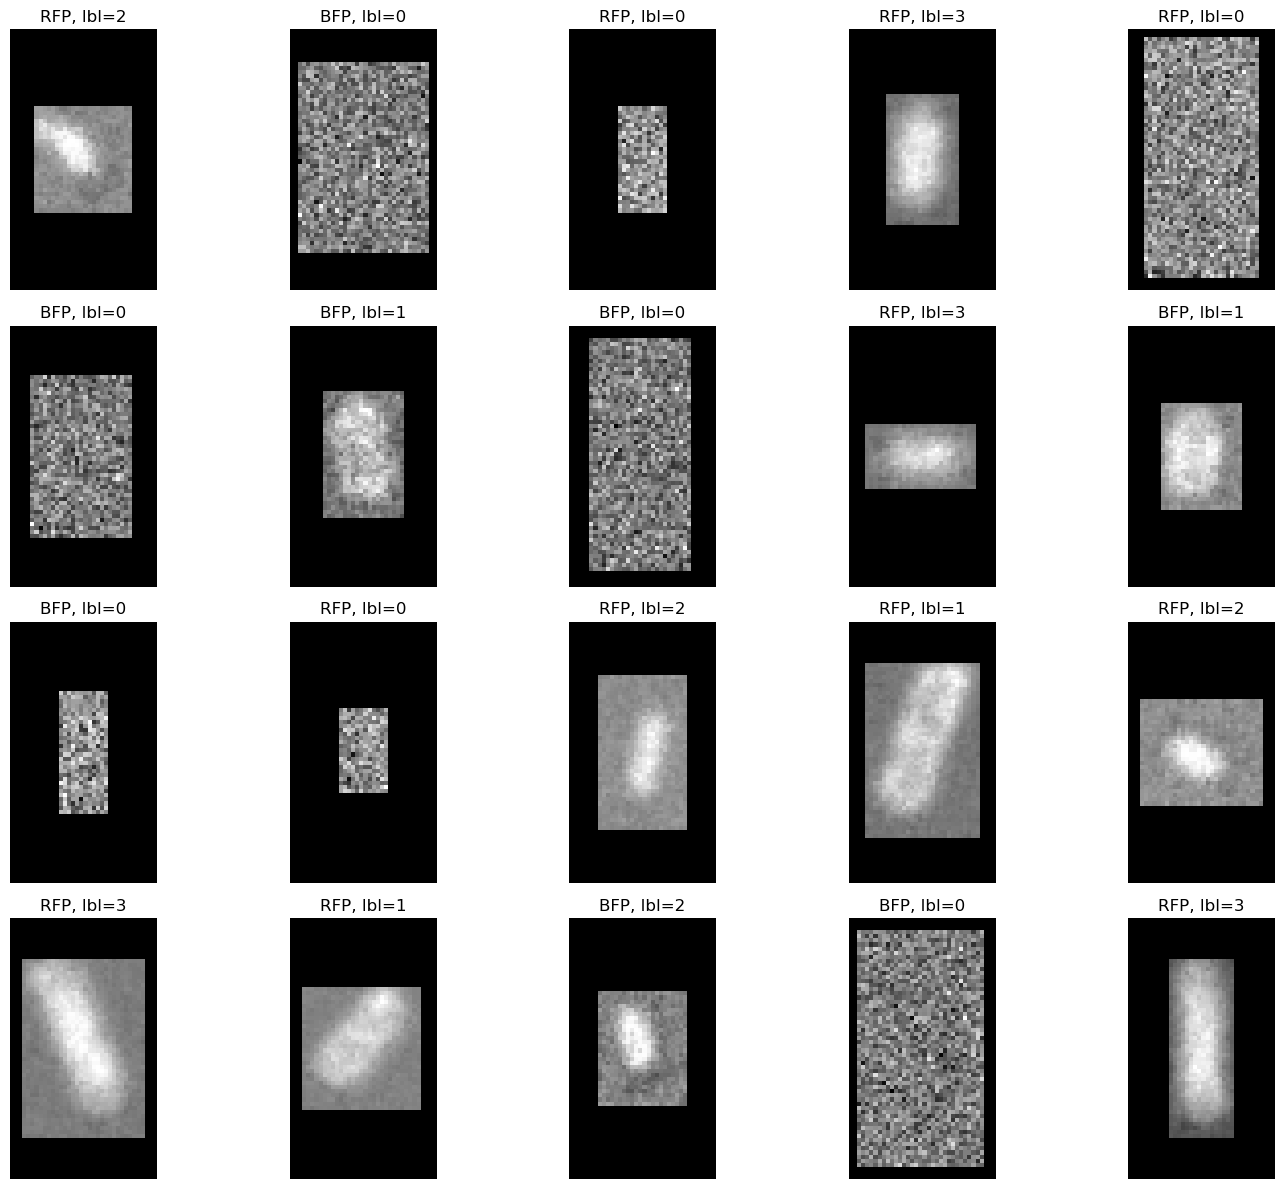

In [ ]:
# Visualize the last 20 synthetic images
import matplotlib.pyplot as plt

# take the last 20 entries
to_show   = all_synth_imgs[-20:]
labels    = all_synth_lbls[-20:]
channels  = all_synth_chs[-20:]

n = len(to_show)  # should be 20
cols = 5
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < n:
        img = to_show[i]
        lbl = labels[i]
        ch  = channels[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{ch}, lbl={lbl}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [31]:
# Cell 7: Save all synthetic images, labels, and channels to one pickle

import pickle

OUT_PATH = r"D:\PRISM\Mother Cell For PRISM Train\Synthetic\synthetic_example_for88.pkl"
with open(OUT_PATH, "wb") as f:
    pickle.dump((all_synth_imgs, all_synth_lbls, all_synth_chs), f)

print(f"✅ Saved {len(all_synth_imgs)} images (and metadata) to {OUT_PATH}")


✅ Saved 80 images (and metadata) to D:\PRISM\Mother Cell For PRISM Train\Synthetic\synthetic_example_for88.pkl


## Augument Synthetic Images

In [186]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.ndimage import rotate, shift
# --- Augmentation functions (as defined previously) ------------------
def tf_rotate(image, angle, order=1):
    def rotate_image(image, angle, order):
        image_np = image.numpy()
        return rotate(image_np, angle, axes=(0, 1), reshape=False, mode="nearest", order=order)
    image_rotated = tf.py_function(rotate_image, [image, angle, order], tf.float32)
    image_rotated.set_shape(image.get_shape())
    return image_rotated

def tf_illumination_voodoo(image, num_control_points=5):
    image = tf.cast(image, tf.float32)
    control_points = tf.linspace(0.0, tf.cast(tf.shape(image)[1], tf.float32) - 1.0, num_control_points)
    random_points = tf.random.uniform([num_control_points], minval=0.78, maxval=1.22)
    interp_points = tf.linspace(0.0, tf.cast(tf.shape(image)[1], tf.float32) - 1.0, tf.shape(image)[1])
    curve = tfp.math.interp_regular_1d_grid(
        interp_points,
        control_points[0],
        control_points[-1],
        random_points,
        fill_value="constant_extension",
    )
    curve = tf.reshape(curve, [1, -1, 1])
    curve = tf.tile(curve, [tf.shape(image)[0], 1, tf.shape(image)[2]])
    return image * curve

def tf_histogram_voodoo(image, num_control_points=1):
    original_points = tf.linspace(0.0, 1.0, num=num_control_points + 2)
    target_points = tf.linspace(0.0, 1.0, num=num_control_points + 2)
    random_values = tf.random.uniform([num_control_points], 0.35, 0.65)
    sorted_random = tf.sort(random_values)
    target_points = tf.tensor_scatter_nd_update(
        target_points,
        tf.reshape(tf.range(1, num_control_points + 1), [-1, 1]),
        sorted_random,
    )
    flat_image = tf.reshape(image, [-1])
    interp_values = tfp.math.interp_regular_1d_grid(
        flat_image,
        original_points[0], original_points[-1],
        target_points,
        fill_value="constant_extension",
    )
    return tf.reshape(interp_values, tf.shape(image))

def tf_add_gaussian_noise(image, gaussian_noise_max=0.1):
    noise_stddev = tf.random.uniform((), 0, gaussian_noise_max)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_stddev)
    noisy = image + noise
    return tf.clip_by_value(noisy, 0, 1)

def tf_apply_gaussian_blur(image, gaussian_blur_sigma_max=3.0):
    channels = image.shape[-1]
    sigma = tf.random.uniform((), 0, gaussian_blur_sigma_max)
    size = tf.cast(tf.math.ceil(sigma * 3), tf.int32)
    d = tfp.distributions.Normal(0.0, sigma)
    vals = d.prob(tf.range(-size, size + 1, dtype=tf.float32))
    gauss_kernel = tf.einsum('i,j->ij', vals, vals)
    gauss_kernel = gauss_kernel / tf.reduce_sum(gauss_kernel)
    gauss_kernel = gauss_kernel[:, :, tf.newaxis, tf.newaxis]
    gauss_kernel = tf.tile(gauss_kernel, [1, 1, channels, 1])
    img4d = tf.expand_dims(image, 0)
    blurred = tf.nn.depthwise_conv2d(img4d, gauss_kernel, strides=[1,1,1,1], padding='SAME')
    return tf.squeeze(blurred, 0)

def tf_shift(image, shift_fraction_y, shift_fraction_x, order=1):
    def shift_image(image, sy, sx, order):
        img = image.numpy()
        dy = int(img.shape[0] * sy)
        dx = int(img.shape[1] * sx)
        return shift(img, [dy, dx, 0], order=order, mode='nearest')
    shifted = tf.py_function(shift_image, [image, shift_fraction_y, shift_fraction_x, order], tf.float32)
    shifted.set_shape(image.get_shape())
    return shifted

def tf_random_rescale_to_fixed_size(image, target_height=64, target_width=36, scale_min=0.7, scale_max=1.2):
    # Get current shape
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    scale = tf.random.uniform([], scale_min, scale_max)

    # Compute new size and resize
    new_h = tf.cast(tf.round(tf.cast(h, tf.float32) * scale), tf.int32)
    new_w = tf.cast(tf.round(tf.cast(w, tf.float32) * scale), tf.int32)
    image_scaled = tf.image.resize(image, [new_h, new_w], method='bilinear')

    # Pad or crop back to original shape
    image_scaled = tf.image.resize_with_crop_or_pad(image_scaled, target_height, target_width)
    return image_scaled


def augment(image, label):
    # assume image shape [H,W,1], dtype float32 in [0,1]
    if tf.random.uniform(()) < 0.5:
        angle = tf.random.uniform((), -180, 180)
        image = tf_rotate(image, angle, order=1)
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_flip_left_right(image)
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_flip_up_down(image)
    
    if tf.random.uniform(()) < 0.5:
        dy = tf.random.uniform((), -0.1, 0.1)
        dx = tf.random.uniform((), -0.1, 0.1)
        image = tf_shift(image, dy, dx, order=1)

    if tf.random.uniform(()) < 0.5:
        image = tf_random_rescale_to_fixed_size(image, 64, 36)

    if tf.random.uniform(()) < 0.1:
        image = tf_illumination_voodoo(image) # makes sharp intensity change
    if tf.random.uniform(()) < 0.1:
        image = tf_histogram_voodoo(image) # saturates image
    if tf.random.uniform(()) < 0.3:
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.85, 1.15) # not bad keep it
    if tf.random.uniform(()) < 0.3:
        image = tf_add_gaussian_noise(image, 0.07) # not bad keep it
    if tf.random.uniform(()) < 0.2:
        image = tf_apply_gaussian_blur(image, 0.5) # not bad keep it
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

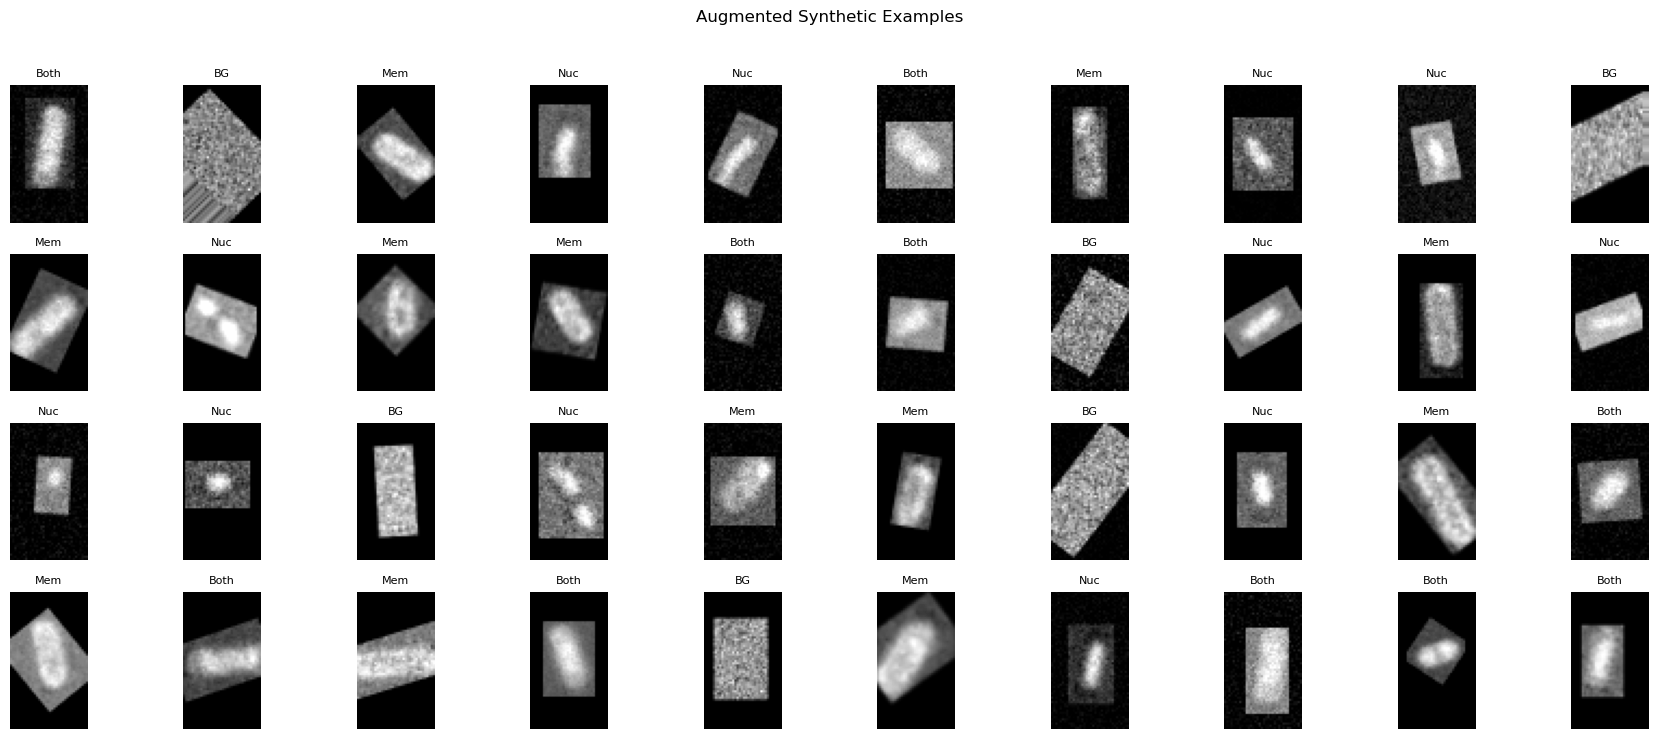

In [ ]:
# Cell: Augment & visualize synthetic images
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1) Load synthetic dataset
PATH = r"D:\PRISM\Mother Cell For PRISM Train\Synthetic\synthetic_example_for88.pkl"
all_synth_imgs, all_synth_lbls, all_synth_chs = pickle.load(open(PATH, "rb"))

# 2) Pick 40 random synthetic examples
rng = np.random.RandomState(42)
idx = rng.choice(len(all_synth_imgs), size=40, replace=False)
samples = [all_synth_imgs[i] for i in idx]
sample_lbls = [all_synth_lbls[i] for i in idx]

# 3) Apply your `augment(...)` function
augmented = []
for im, lbl in zip(samples, sample_lbls):
    # convert to float32 [0..1], add channel dim if needed
    im_tf = tf.convert_to_tensor(im, dtype=tf.float32)
    if im_tf.ndim == 2:
        im_tf = tf.expand_dims(im_tf, -1)
    # normalize just in case
    im_tf = (im_tf - tf.reduce_min(im_tf)) / (tf.reduce_max(im_tf) - tf.reduce_min(im_tf) + 1e-8)
    aug_im, _ = augment(im_tf, lbl)
    augmented.append(aug_im.numpy().squeeze())

# 4) Visualize
rows, cols = 4, 10
fig, axes = plt.subplots(rows, cols, figsize=(cols*1.8, rows*1.8))

label_names = {0:"BG",1:"Mem",2:"Nuc",3:"Both"}
for i, ax in enumerate(axes.flat):
    ax.imshow(augmented[i], cmap='gray')
    ax.set_title(label_names[sample_lbls[i]], fontsize=8)
    ax.axis('off')

plt.suptitle("Augmented Synthetic Examples", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
import os, pickle
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.ndimage import rotate, shift
from tqdm.auto import tqdm
# ─── CONFIG ─────────────────────────────────────────────────────────────
SYN_PKL = r"D:\PRISM\Mother Cell For PRISM Train\Synthetic\synthetic_example_for88.pkl"
OUT_PKL = r"D:\PRISM\Mother Cell For PRISM Train\Synthetic\synthetic_augmented_for88.pkl"

# specify exactly how many you want *per class*:
targets_per_class = {
    0: 10000,
    1: 10000,
    2: 15000,
    3: 15000
}
# ────────────────────────────────────────────────────────────────────────
# ─── LOAD SYNTHETIC ───────────────────────────────────────────────────────
with open(SYN_PKL, "rb") as fh:
    all_synth_imgs, all_synth_lbls, _ = pickle.load(fh)

labels_arr  = np.array(all_synth_lbls, dtype=int)
unique_lbls = np.unique(labels_arr)
by_label_idxs = {lbl: np.where(labels_arr == lbl)[0].tolist()
                 for lbl in unique_lbls}

rng = np.random.RandomState(123)
aug_images, aug_labels = [], []

# ─── AUGMENT PER CLASS ───────────────────────────────────────────────────
for lbl in unique_lbls:
    idxs  = by_label_idxs[lbl]
    target = targets_per_class.get(lbl, 0)
    print(f"> Class {lbl}: have {len(idxs)} originals, target {target}")
    pbar = tqdm(total=target, desc=f"Class {lbl}", leave=False)

    count = 0
    while count < target:
        i   = rng.choice(idxs)
        im  = all_synth_imgs[i]
        t   = tf.convert_to_tensor(im.astype(np.float32))
        if t.ndim == 2: t = tf.expand_dims(t, -1)
        t   = (t - tf.reduce_min(t)) / (tf.reduce_max(t) - tf.reduce_min(t) + 1e-8)
        aug, _ = augment(t, lbl)
        out = aug.numpy().squeeze()
        # re-normalize to [0,1]
        mn, mx = out.min(), out.max()
        out = (out - mn) / (mx - mn + 1e-8)

        aug_images.append(out)
        aug_labels.append(lbl)

        count += 1
        pbar.update(1)
    pbar.close()

# ─── SHUFFLE & SAVE ─────────────────────────────────────────────────────
combined = list(zip(aug_images, aug_labels))
rng.shuffle(combined)
aug_images, aug_labels = zip(*combined)
with open(OUT_PKL, "wb") as fh:
    pickle.dump((list(aug_images), list(aug_labels)), fh)

print(f"\n✅ Saved augmented synthetic to {OUT_PKL}")
print(f"   total = {sum(targets_per_class.values())} examples")


> Class 0: have 5839 originals, target 10000


Class 0:   0%|          | 0/10000 [00:00<?, ?it/s]

> Class 1: have 5796 originals, target 10000


Class 1:   0%|          | 0/10000 [00:00<?, ?it/s]

> Class 2: have 5790 originals, target 15000


Class 2:   0%|          | 0/15000 [00:00<?, ?it/s]

> Class 3: have 5875 originals, target 15000


Class 3:   0%|          | 0/15000 [00:00<?, ?it/s]


✅ Saved augmented synthetic to D:\PRISM\Mother Cell For PRISM Train\Synthetic\synthetic_augmented.pkl
   total = 50000 examples


Merge Real and Synthetic Dataset (Setup 4)

In [ ]:
import os
import pickle
import random

# ─── PATHS ───────────────────────────────────────────────────────────────
BASE          = os.getcwd()
REAL_PKL      = r"D:\PRISM\Mother Cell For PRISM Train\merged\CNN_dataset\augmented_train.pkl"
SYN_PKL       = r"D:\PRISM\Mother Cell For PRISM Train\Synthetic\synthetic_augmented_for88.pkl"
MERGED_PKL    = r"D:\PRISM\Mother Cell For PRISM Train\merged\CNN_dataset\real_and_synthetic_augumented.pkl"

# ─── LOAD both datasets ───────────────────────────────────────────────────
with open(REAL_PKL, "rb") as f:
    real_images, real_labels = pickle.load(f)

with open(SYN_PKL, "rb") as f:
    synth_images, synth_labels = pickle.load(f)

print(f"Loaded {len(real_images)} real examples and {len(synth_images)} synthetic examples.")

# ─── MERGE ────────────────────────────────────────────────────────────────
combined = list(zip(real_images, real_labels)) + list(zip(synth_images, synth_labels))

# optional: shuffle so real & synthetic are well mixed
random.seed(123)
random.shuffle(combined)

merged_images, merged_labels = zip(*combined)
merged_images = list(merged_images)
merged_labels = list(merged_labels)

print(f"Merged dataset size: {len(merged_images)} examples.")

# ─── SAVE MERGED DATASET ─────────────────────────────────────────────────
with open(MERGED_PKL, "wb") as f:
    pickle.dump((merged_images, merged_labels), f)

print(f"Saved merged dataset to {MERGED_PKL}")


Loaded 60000 real examples and 50000 synthetic examples.
Merged dataset size: 110000 examples.
Saved merged dataset to D:\PRISM\Mother Cell For PRISM Train\merged\CNN_dataset\real_and_synthetic_augumented.pkl


## Make 0000 Test image

In [10]:
# Cell: Build 0000_test.zarr from synthetic backgrounds (fixed H,W)
import os, zarr, random
import numpy as np

# ─── CONFIG ─────────────────────────────────────────────────────────────
OUT_DIR = r"D:\PRISM\Test All\test_sets"
OUT_PATH = os.path.join(OUT_DIR, "0000_test.zarr")
NUM_SYN = 341   # number of background crops per channel
# ────────────────────────────────────────────────────────────────────────

os.makedirs(OUT_DIR, exist_ok=True)

# infer H,W from your real_images list
H, W = real_images[0].shape
print(f"Using crop size H×W = {H}×{W}")

# prepare arrays
bfp_list = np.zeros((NUM_SYN, H, W), dtype=np.float32)
rfp_list = np.zeros_like(bfp_list)

print(f"Generating {NUM_SYN} synthetic background crops for code 0000…")
for i in range(NUM_SYN):
    # pick a random real example for BFP
    k = random.randrange(len(real_images))
    real_img = real_images[k]
    M0, S0   = MS_list[k]
    syn_bfp, _, _ = generate_synthetic_for_real(real_img, M0, S0,
                                                channel="BFP", label=0)
    bfp_list[i] = syn_bfp

    # pick another (or same) random real example for RFP
    k2 = random.randrange(len(real_images))
    real_img2 = real_images[k2]
    M1, S1    = MS_list[k2]
    syn_rfp, _, _ = generate_synthetic_for_real(real_img2, M1, S1,
                                                channel="RFP", label=0)
    rfp_list[i] = syn_rfp

    if (i+1) % 25 == 0:
        print(f"  ✔ {i+1}/{NUM_SYN}")

# ─── Write to Zarr ───────────────────────────────────────────────────────
# remove old if it exists
if os.path.isdir(OUT_PATH):
    import shutil
    shutil.rmtree(OUT_PATH)

zgrp = zarr.open(OUT_PATH, mode="w")
# chunk along first axis for faster access
zgrp.create_dataset("bfp", data=bfp_list, chunks=(10, H, W))
zgrp.create_dataset("rfp", data=rfp_list, chunks=(10, H, W))

print(f"\n✅ Written 0000_test.zarr to {OUT_PATH}")
print("   Datasets:")
print("    - bfp:", bfp_list.shape)
print("    - rfp:", rfp_list.shape)


Using crop size H×W = 64×36
Generating 341 synthetic background crops for code 0000…
  ✔ 25/341
  ✔ 50/341
  ✔ 75/341
  ✔ 100/341
  ✔ 125/341
  ✔ 150/341
  ✔ 175/341
  ✔ 200/341
  ✔ 225/341
  ✔ 250/341
  ✔ 275/341
  ✔ 300/341
  ✔ 325/341

✅ Written 0000_test.zarr to D:\PRISM\Test All\test_sets\0000_test.zarr
   Datasets:
    - bfp: (341, 64, 36)
    - rfp: (341, 64, 36)
